In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My\ Drive/Colab_Notebooks

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab_Notebooks


In [2]:
%cd coursera-deep-learning-specialization-master/C4\ \-\ Convolutional\ Neural\ Networks/Week\ 2/ResNets

/content/drive/My Drive/Colab_Notebooks/coursera-deep-learning-specialization-master/C4 - Convolutional Neural Networks/Week 2/ResNets


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [11]:
def identity_block(X, f, filters, stage, block):

  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  F1, F2, F3 = filters

  X_shortcut = X

  X = Conv2D(F1, (1,1), strides=(1,1), padding='valid', name = conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
  X = Activation('relu')(X)

  X = Conv2D(F2, (f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base+'2b')(X)
  X = Activation('relu')(X)

  X = Conv2D(F3, (1,1), strides=(1,1), padding='valid', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)
  
  #X = X + X_shortcut
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

In [12]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.94822997 0.         1.1610146  2.747859   0.         1.36677   ]


In [13]:
def convolutional_block(X, f, filters, stage, block, s = 2):

  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  F1, F2, F3 = filters

  X_shortcut = X

  X = Conv2D(F1, (1,1), strides=(s,s), padding='valid', name = conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
  X = Activation('relu')(X)

  X = Conv2D(F2, (f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base+'2b')(X)
  X = Activation('relu')(X)

  X = Conv2D(F3, (1,1), strides=(1,1), padding='valid', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)
  
  X_shortcut = Conv2D(F3, (1,1), strides=(s,s), padding='valid', name=conv_name_base+'1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3, name = bn_name_base+'1')(X_shortcut)

  #X = X + X_shortcut
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.09018461 1.2348979  0.4682202  0.03671762 0.         0.65516603]


In [15]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
  X_input = Input(input_shape)

  X = ZeroPadding2D((3,3))(X_input) #70x70x3

  #stage 1
  X = Conv2D(64, (7,7), strides=(2,2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X) #32x32x64
  X = BatchNormalization(axis = 3, name = 'bc_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3,3), strides= (2,2))(X)              #16x16x64

  #stage 2
  X = convolutional_block(X, 3, [64,64,256], stage=2, block='a', s=1) #16x16x256
  X = identity_block(X, 3, [64,64,256], stage=2, block='b')
  X = identity_block(X, 3, [64,64,256], stage=2, block='c')

  #stage 3
  X = convolutional_block(X, 3, [128,128,512], stage=3, block='a', s=2)
  X = identity_block(X, 3, [128,128,512], stage=3, block='b')
  X = identity_block(X, 3, [128,128,512], stage=3, block='c')
  X = identity_block(X, 3, [128,128,512], stage=3, block='d')

  #stage 4
  X = convolutional_block(X, 3, [256,256,1024], stage=4, block='a', s=2)
  X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
  X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
  X = identity_block(X, 3, [256,256,1024], stage=4, block='d')
  X = identity_block(X, 3, [256,256,1024], stage=4, block='e')
  X = identity_block(X, 3, [256,256,1024], stage=4, block='f')

  #stage 5
  X = convolutional_block(X, 3, [512,512,2048], stage=5, block='a', s=2)
  X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
  X = identity_block(X, 3, [512,512,2048], stage=5, block='c')

  X = AveragePooling2D((2,2), padding='same')(X)
  X = Flatten()(X)
  X = Dense(classes, activation='softmax', name= 'fc'+str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

  model = Model(inputs = X_input, outputs = X, name = 'ResNet50')

  return model


In [17]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [ ]:
model.fit(X_train, Y_train, batch_size= 32, epochs = 30)

Epoch 1/30
1080/1080 [==============================] - 202s 187ms/step - loss: 0.0135 - accuracy: 0.9944
Epoch 2/30
1080/1080 [==============================] - 187s 173ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 3/30
1080/1080 [==============================] - 184s 171ms/step - loss: 0.0023 - accuracy: 0.9991
Epoch 4/30
1080/1080 [==============================] - 184s 170ms/step - loss: 0.0325 - accuracy: 0.9954
Epoch 5/30
1080/1080 [==============================] - 185s 171ms/step - loss: 0.0410 - accuracy: 0.9889
Epoch 6/30
1080/1080 [==============================] - 185s 171ms/step - loss: 0.0282 - accuracy: 0.9944
Epoch 7/30
1080/1080 [==============================] - 185s 171ms/step - loss: 0.0052 - accuracy: 0.9981
Epoch 8/30
1080/1080 [==============================] - 183s 169ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 9/30
1080/1080 [==============================] - 180s 166ms/step - loss: 2.9735e-04 - accuracy: 1.0000
Epoch 10/30
 736/1080 [===================

In [35]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 3s 22ms/step
Loss = 1.3798930803934732
Test Accuracy = 0.7749999761581421


In [36]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bc_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

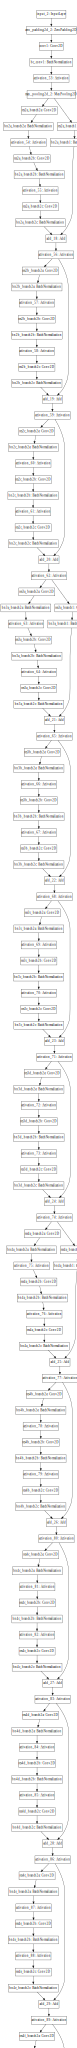

In [33]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))